In [2]:
import numpy as np
import astropy.units as u

from astropy.table import QTable
from os import listdir
from matplotlib import pyplot as plt


def perform_Gaia_query(G_lim, filename):
    """Perform a query from Gaia EDR3.

    The query will include all the stars brighter with G<G_lim that also have a 5-parameter
    astrometric solution together with BP and RP measurements. Their astrometric parameters,
    uncertainties and correlations together with G, BP and RP magnitudes are saved to a VOTable.
    The name of the VOTable file is returned.
    """
    from astroquery.gaia import Gaia

    astrometry = ('ra', 'dec', 'parallax', 'pmra', 'pmdec')
    columns_to_query = ''
    # Add astrometric measurements, uncertanties and correlations to the columns to be queried
    for i, col in enumerate(astrometry):
        columns_to_query += col+', '
        columns_to_query += col+'_error, '
        for col2 in astrometry[i+1:]:
            columns_to_query += col+'_'+col2+'_corr, '
    # Make sure the magnitudes in the three bands are queried too
    for band in ('g', 'bp', 'rp'):
        columns_to_query += 'phot_'+band+'_mean_mag, '
    # Remove the last comma
    columns_to_query = columns_to_query[:-2]
    job = Gaia.launch_job_async(f'SELECT {columns_to_query} FROM gaiaedr3.gaia_source '
                                f'WHERE phot_g_mean_mag < {G_lim} AND parallax IS NOT NULL '
                                'AND bp_rp IS NOT NULL ;',
                                dump_to_file=True, output_file=filename)
    return job.outputFile


G_lim = 11
filename = f'brighter_than_{G_lim}.vot'
if filename not in listdir():
    print('Performing a query from Gaia archive. This might take a while...')
    perform_Gaia_query(G_lim, filename)
else:
    print('Reading data from a stored file.')
data = QTable.read(filename, unit_format='vounit')
print('Done.')

Reading data from a stored file.
Done.


#### Coordinate transformation

We saw in project 0 that the *Gaia* data releases contain galactic coordinates of the sources, but they only contain proper motions in the ICRS coordinates.
We therefore need to convert the astrometry from ICRS coordinates from *Gaia* to the galactic system.
Coordinate conversion could be done very easily using `astropy`, but to ensure that the uncertainties are also converted we will use the module `coordTransform.py` instead.
Somewhat unfortunately that module is meant to work with `numpy` arrays rather than `astropy` Tables, but the code below takes care of the necessary conversions.

In [3]:
def construct_covariance_matrix(stars):
    """Create the covariance matrix of the astrometric parameters of input stars."""
    covariance = np.ones((len(stars), 5, 5))
    astrometry = ('ra', 'dec', 'parallax', 'pmra', 'pmdec')
    for i, col in enumerate(astrometry):
        # This covariance matrix is set up as a numpy array, so we need to strip the units.
        covariance[:, i, :] *= np.array(stars[col+'_error'])[:, np.newaxis]
        covariance[:, :, i] *= np.array(stars[col+'_error'])[:, np.newaxis]
        for j in range(i+1, 5):
            covariance[:, i, j] *= np.array(stars[col+'_'+astrometry[j]+'_corr'])
            covariance[:, j, i] = covariance[:, i, j]
    return covariance


def convert_icrs_to_gal(stars):
    """Convert coordinates from ICRS to the Galactic system."""
    from coordTransform import transformIcrsToGal
    gal_params = ('l', 'b', 'pml', 'pmb')
    coords = np.array(stars['ra', 'dec', 'parallax', 'pmra', 'pmdec']).view((float, 5))
    covariance = construct_covariance_matrix(stars)
    gal_coords, gal_uncerts, gal_covariance = transformIcrsToGal(coords, 0, EqC=covariance)
    temp = QTable(gal_coords[:, [0, 1, 3, 4]], names=gal_params)
    stars.add_columns(list(temp.itercols()))
    for i, name, unit, err_unit in zip((0, 1, 3, 4), gal_params,
                                       (u.deg, u.deg, u.mas/u.yr, u.mas/u.yr),
                                       (u.mas, u.mas, u.mas/u.yr, u.mas/u.yr)):
        stars[name] *= unit
        # Right ascension and declination are in deg, but their uncertanties in mas.
        # We must ensure the same for galactic longitude and latitude.
        stars[name+'_error'] = np.sqrt(gal_covariance[:, i, i])*err_unit
    return stars


# Don't compute the galactic coordinates if they are already computed.
if 'b' not in data.columns:
    data = convert_icrs_to_gal(data)

In [4]:
mu = 1*u.mas/u.yr
print(f'{mu} is {mu.to(u.km/u.s/u.kpc, equivalencies=u.dimensionless_angles()):.4f}.')

1.0 mas / yr is 4.7405 km / (kpc s).


Project 2

In [6]:
plt.rcParams['xtick.minor.visible'], plt.rcParams['xtick.top'] = True,True 
plt.rcParams['ytick.minor.visible'], plt.rcParams['ytick.right'] = True,True 
plt.rcParams['xtick.direction'], plt.rcParams['ytick.direction'] = 'in','in'

C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\astropy\units\quantity.py:486: RuntimeWarning: invalid value encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\calum\AppData\Local\Temp/ipykernel_30964/3693345447.py:161: RuntimeWarning: divide by zero encountered in log
  z_dens[kdx] = np.log(len(newsel['z'])/totvol.value)


Number of star after 1st selection in bin 1 lower than 200: Only 144 stars.
Number of stars after 2nd selection in bin 1 lower than 200: Only 114 star(s).


C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\calum\AppData\Local\Temp/ipykernel_30964/3693345447.py:161: RuntimeWarning: divide by zero encountered in log
  z_dens[kdx] = np.log(len(newsel['z'])/totvol.value)
C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\calum\miniconda3\envs\main-env\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\calum\AppData\Local\Temp/ipykernel_30964/3693345447.py:161: RuntimeWarning: divide by zero encou

-7.334124078259085
-7.334124078259085


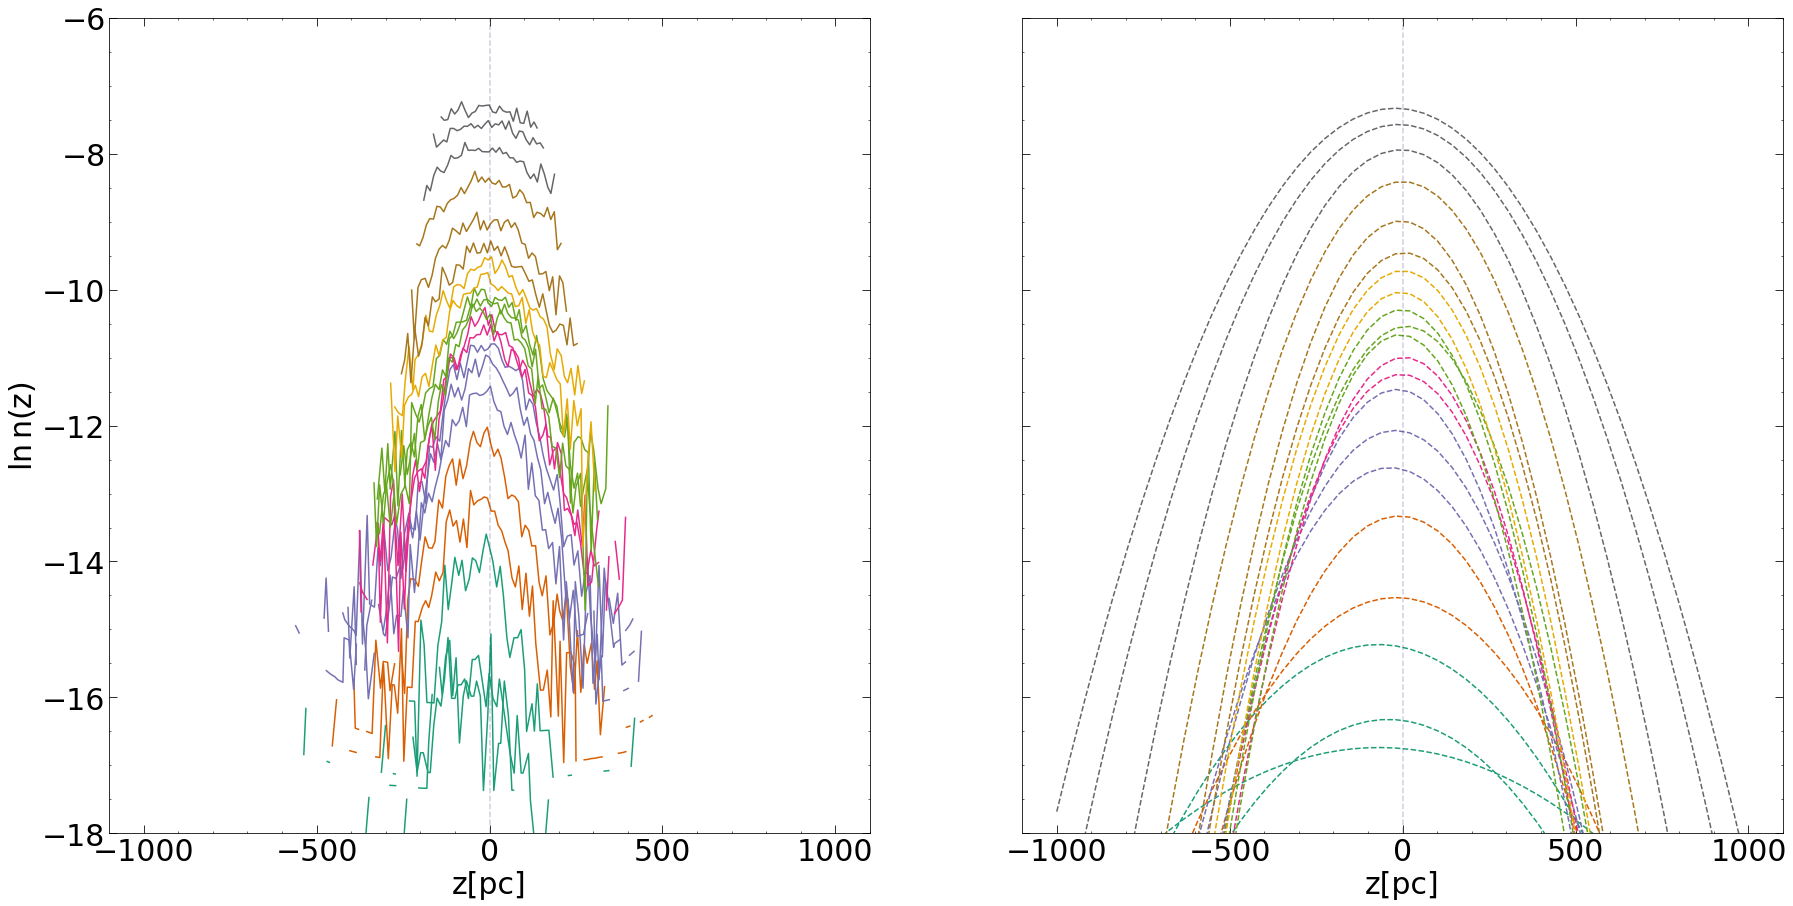

In [58]:
plt.rcParams['font.size'] = 30
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
#from tqdm import tqdm

plt.rcParams['text.usetex'] = False
plt.rcParams['pcolor.shading']

#create bp-rp and absolute magnitude entries in data
data["bp-rp"] = data["phot_bp_mean_mag"] - data["phot_rp_mean_mag"]
data["phot_abs"] = data["phot_g_mean_mag"] + 5*np.log10(data["parallax"]/(100*u.mas))*u.mag

start = -0.30
end = .75
stepsize = 0.05


jet= plt.get_cmap('Dark2')
length = np.arange(start,end,stepsize).size
colors = iter(jet(np.linspace(0,1,length)))

# initialise lists for Qtable
v = np.empty((3,length))*u.km/u.s
v_disp = np.empty((3,length))*(u.km*u.km)/(u.s*u.s)
d_mat_list = np.empty((6,length))*(u.km*u.km)/(u.s*u.s)
maxdist = np.empty(length)*u.pc
clrrange_low = np.empty(length)*u.mag
clrrange_upp = np.empty(length)*u.mag
avgclr = np.empty(length)*u.mag
faintest = np.empty(length)*u.mag
minpar = np.empty(length)*u.mas
nstars = np.empty(length)
shifts = np.empty(length)

# ages
max_age = [1.26e8,2e8,2.8e8,3.98e8,5.01e8,6e8,7e8,7.94e8,9e8,1e9,1.13e9,1.26e9,1.36e9,1.58e9,1.85e9,2.25e9,2.75e9,3.98e9,5.6e9,7.94e9,1e10]*u.yr
age = max_age/2
colors = iter(jet(np.linspace(0,1,length)))
Q = np.empty(length)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize =(30,15), sharey=True, sharex=True)

for idx, i in enumerate(np.arange(start,end,stepsize)):
    # colour bin selection
    low_clr = i*u.mag 
    upp_clr = (i+stepsize)*u.mag
    clrrange_low[idx] = low_clr
    clrrange_upp[idx] = upp_clr

    # selection 1
    low_abs_err = data['parallax_error'] < 1*u.mas
    low_error = data["parallax_error"] / data["parallax"] < 0.1
    clr_low = data["bp-rp"] > low_clr
    clr_upp = data["bp-rp"] < upp_clr
    clr_range = clr_low*clr_upp
    selection = data[clr_range*low_error*low_abs_err]
    greysel = selection
    
    # selection 2

    if selection["phot_abs"].shape[0] < 200:
        print(f'Number of star after 1st selection in bin {idx+1} lower than 200: Only {selection["phot_abs"].shape[0]} stars.')
    meanphot = np.nanmean(selection["phot_abs"].value)
    stdphot = np.nanstd(selection["phot_abs"].value)
    photlow = selection["phot_abs"].value > meanphot - 2*stdphot
    photupp = selection["phot_abs"].value < meanphot + 2*stdphot
    selection = selection[photlow&photupp]
        
    # selection 3
    
    maxdist[idx] = (10*u.pc)*10**((G_lim-np.nanmax(selection["phot_abs"].value))/5)
    #print(f"Maximum distance for that the data is complete: {maxdist[idx]:.3f}")

    minparlim = (100*u.mas)*10**((np.nanmax(selection['phot_abs'].value)-G_lim)/5)
    minparmask = selection['parallax'] > minparlim
    selection = selection[minparmask]
    if selection["phot_abs"].shape[0] < 200:
        print(f'Number of stars after 2nd selection in bin {idx+1} lower than 200: Only {selection["phot_abs"].shape[0]} star(s).')

    nstars[idx] = selection["b"].shape[0]
    b = selection["b"]
    l = selection["l"]
    p = selection["parallax"]
    mul = selection["pml"]
    mub = selection["pmb"]

    #velocity
    uvec = uvecf(b,l)
    lvec = lvecf(l)
    bvec = bvecf(b,l)
    tauvec = tauvecf(l,b,p,mul,mub)
    tmatinv = np.linalg.inv(np.mean(tmatf(uvec), axis = 2))
    vvec = tmatinv @ np.mean(tauvec, axis=1)
    v[:,idx] = vvec

    # velocity dispersion
    deltatau = tauvec - np.sum((tmatf(uvec) * vvec[:,np.newaxis,np.newaxis]), axis=1)

    bmat = np.mean(deltatau[:,np.newaxis,:]*deltatau[np.newaxis,:,:],axis=2)

    tvec_long = tmatf(uvec)
    bmatflat = bmat[np.triu_indices(3)]
    tvecflat = tvec_long[:,:][np.triu_indices(3)]

    # A-matrix
    helper = tvecflat[:,np.newaxis,:]*tvecflat[np.newaxis,:,:]
    A = np.empty((6,6,selection["phot_abs"].shape[0]))
    A[0,:] = [helper[0,0], helper[0,1]+helper[1,0], helper[0,2]+helper[2,0], helper[1,1], helper[1,2]+helper[2,1], helper[2,2]]
    A[1,:] = [helper[0,1], helper[0,3]+helper[1,1], helper[0,4]+helper[2,1], helper[1,3], helper[1,4]+helper[2,3], helper[2,4]]
    A[2,:] = [helper[0,2], helper[0,4]+helper[1,2], helper[0,5]+helper[2,2], helper[1,4], helper[1,5]+helper[2,4], helper[2,5]]
    A[3,:] = [helper[1,1], helper[1,3]+helper[3,1], helper[1,4]+helper[4,1], helper[3,3], helper[3,4]+helper[4,3], helper[4,4]]
    A[4,:] = [helper[1,2], helper[1,4]+helper[3,2], helper[1,5]+helper[4,2], helper[3,4], helper[3,5]+helper[4,4], helper[4,5]]
    A[5,:] = [helper[2,2], helper[2,4]+helper[4,2], helper[2,5]+helper[5,2], helper[4,4], helper[4,5]+helper[5,4], helper[5,5]]

    A = np.mean(A, axis=2)

    dmat = np.linalg.inv(A) @ bmatflat
    d_mat_list[:,idx] = dmat
    v_disp[:,idx] = [dmat[0],dmat[3],dmat[5]]
    
    
    # P4 
    
    #compute max distance
    selection['dist'] = 1000*u.mas*u.pc/selection['parallax']
    dist_vis = selection['dist'].value
    selection['z'] = np.sin(selection['b'])*selection['dist']
    
    # bin the z-values
    z_min = np.min(selection['z'].value)
    z_max = np.max(selection['z'].value)
    
    z_range = np.arange(z_min, z_max, 10)
    
    z_mean = np.empty(len(z_range)-1)
    z_antal = np.empty(len(z_range)-1)
    z_dens = np.empty(len(z_range)-1)

    # loop through the bins
    for kdx in range(len(z_range)-1):
        z_low = z_range[kdx]*u.pc
        z_upp = z_range[kdx+1]*u.pc
        
        z_lowm = selection['z'] > z_low
        z_uppm = selection['z'] < z_upp
        
        totsel = z_lowm*z_uppm
        newsel = selection[totsel]
        
        h1 = 2*maxdist[idx] - (z_low + maxdist[idx])
        h2 = 2*maxdist[idx] - (z_upp + maxdist[idx])
        
        # compute volume within z-bounds
        vol1 = np.pi/3 * h1**2 * (3*maxdist[idx]-h1)
        vol2 = np.pi/3 * h2**2 * (3*maxdist[idx]-h2)
        totvol = np.abs(np.abs(vol2)-np.abs(vol1))
        if totvol == 0:
            print('NULL')
        
        z_mean[kdx] = np.mean(newsel['z'].value)
        z_dens[kdx] = np.log(len(newsel['z'])/totvol.value)
        z_antal[kdx] = len(newsel['z'])
    nextclr = next(colors)
    axs[0].plot(z_mean, z_dens, color = nextclr)
    z_m = z_antal > 0
    
    # polyfit parabolas
    poly, covmats = np.polyfit(z_mean[z_m], z_dens[z_m], deg=2, cov=True)
    shifts[idx] = poly[2]
    linz = np.linspace(-1000,1000,50)
    axs[1].plot(linz, poly[0]*linz**2 + poly[1]*linz + poly[2], color = nextclr, ls='--')
    
    Q[idx] = 2*poly[0]

print(poly[2])
    
plt.ylim((-18,-6))
axs[0].set_ylabel(r'$\ln$n(z)')
axs[0].set_xlabel('z[pc]')
axs[1].set_xlabel('z[pc]')
axs[0].axvline(0, linestyle = '--', color = 'darkslateblue', alpha=0.25)
axs[1].axvline(0, linestyle = '--', color = 'darkslateblue', alpha=0.25)

plt.savefig('curves.png')
plt.show()



[-0.00325318 -0.00038025 -0.00048296 -0.00068939 -0.00102721 -0.00110672
 -0.00227811 -0.00214196 -0.00205443 -0.00268648 -0.00314828 -0.00266741
 -0.00320234 -0.00390072 -0.0035805  -0.00395368 -0.00467783 -0.00569575
 -0.00636548 -0.00706751 -0.00781311] solMass / pc3


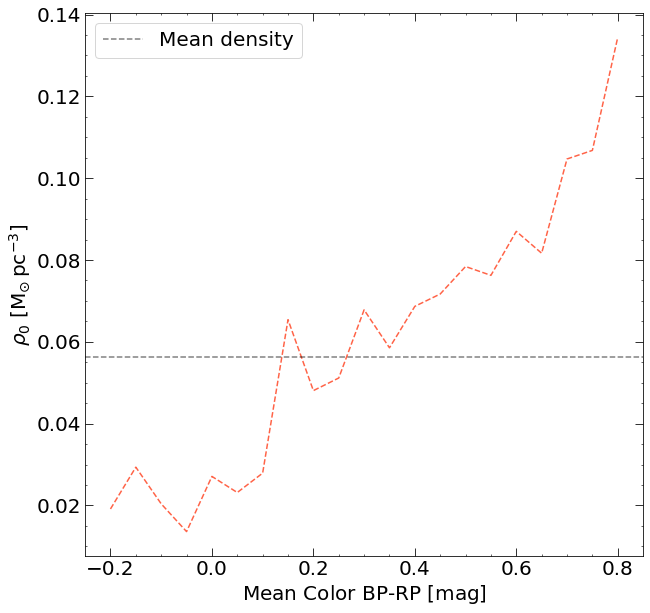

0.05634300069266719


In [57]:
from astropy.constants import G
stellG = G.to(u.pc*u.km*u.km/u.solMass/u.s/u.s)
plt.rcParams['font.size'] = 20
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['ytick.major.size'] = 8
plt.figure(figsize=(10,10))
density = -Q/u.pc/u.pc*v_disp[2,:]/(4*np.pi*stellG)

#uncertainties
uncert_w = 2*v_disp[2,:]/np.sqrt(2*(nstars-1)) 
un_density = -Q/u.pc/u.pc*uncert_w/(4*np.pi*stellG)
un_density_mean = np.mean(un_density)

#plotting
plt.plot(avgclr, density, ls='--', c='tomato')
plt.axhline(np.mean(density[:-1].value), ls='--', alpha=0.5, color='k', label='Mean density')
print(Q/u.pc/u.pc*un/(4*np.pi*stellG))
plt.ylabel(r'$\rho_0$ '+f'[{density.unit.to_string("latex_inline")}]')
plt.xlabel(f'Mean Color BP-RP [{avgclr.unit.to_string("latex_inline")}]')
plt.legend()

plt.savefig('rho0.png')
plt.show()
print(np.mean(density[:-1].value))
#print(un_density_mean)